In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from collections import defaultdict
import matplotlib.pyplot as plt

In [11]:
# 1. 構建特徵提取模塊 (1D CNN)
def build_feature_extractor(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # 第一層卷積層 + 平均池化層
    model.add(layers.Conv1D(filters=128, kernel_size=4, strides=1, padding='same', activation='relu'))
    model.add(layers.AveragePooling1D(pool_size=4))

    # 第二層卷積層 + 最大池化層
    model.add(layers.Conv1D(filters=128, kernel_size=4, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=4))

    return model

# 2. **基於動態路由的 Capsule-like 解耦合分類器**
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routing_iters=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routing_iters = routing_iters

    def build(self, input_shape):
        # 創建權重矩陣，簡化為三維以便運算
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.capsule_dim],
                                 initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        # reshape inputs 的最後一個維度，使其與 self.W 的形狀兼容
        inputs_hat = tf.einsum('bij,jk->bik', inputs, self.W)

        # 重塑 inputs_hat 以適應膠囊結構
        inputs_hat = tf.reshape(inputs_hat, [-1, tf.shape(inputs)[1], self.num_capsules, self.capsule_dim])

        # 動態獲取 inputs_hat 的形狀
        batch_size = tf.shape(inputs_hat)[0]
        input_dim = tf.shape(inputs_hat)[1]

        # 初始化耦合係數
        b = tf.zeros(shape=[batch_size, input_dim, self.num_capsules])

        # 動態路由
        for i in range(self.routing_iters):
            c = tf.nn.softmax(b, axis=2)  # 使用 softmax 更新耦合係數
            s = tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=1)  # 計算輸出向量
            v = self.squash(s)  # 使用 squash 函數縮放向量
            if i < self.routing_iters - 1:
                b += tf.reduce_sum(inputs_hat * tf.expand_dims(v, 1), axis=-1)  # 更新耦合係數
        return v

    def squash(self, s):
        # 縮放函數，用於規範向量的長度
        s_norm = tf.norm(s, axis=-1, keepdims=True)
        scale = s_norm**2 / (1 + s_norm**2)
        return scale * s / (s_norm + 1e-9)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.capsule_dim)

# 構建膠囊分類器
def build_capsule_classifier(input_shape, num_capsules, capsule_dim, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # 膠囊層，處理輸入的高維數據
    capsule_layer = CapsuleLayer(num_capsules=num_capsules, capsule_dim=capsule_dim)(inputs)

    # 扁平化膠囊層的輸出
    flat_caps = layers.Flatten()(capsule_layer)

    # 輸出層: 多標籤分類，使用 sigmoid 激活函數
    outputs = layers.Dense(num_classes, activation='sigmoid')(flat_caps)

    return tf.keras.Model(inputs, outputs)

# 3. Margin Loss 函數
def margin_loss(y_true, y_pred):
    m_plus = 0.9  # 正類的上限
    m_minus = 0.1  # 負類的下限
    lambd = 0.5   # 權重係數，用於對未出現的類進行懲罰

    # 計算 margin loss，確保正類輸出接近1，負類輸出接近0
    L = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) + \
        lambd * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))

    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [5]:
# 設置默認工作目錄
folder_path = '/content/drive/MyDrive/20240715_大馬達收集資料'
os.chdir(folder_path)

# 定義資料夾和標籤（多標籤）
folders = ["齒輪不對中、軸承內斷", "齒輪不對中、軸承正常", "齒輪正常、軸承內斷", "齒輪正常、軸承正常", "齒輪磨耗、軸承內斷", "齒輪磨耗、軸承正常"]
labels_map = {
    # 都正常 - 0 齒輪磨耗 - 1  齒輪不對中 - 2  軸承內斷 - 3
    "齒輪正常、軸承正常": [0],
    "齒輪磨耗、軸承正常": [1],
    "齒輪不對中、軸承正常": [2],
    "齒輪正常、軸承內斷": [3],
    "齒輪磨耗、軸承內斷": [1, 3],
    "齒輪不對中、軸承內斷": [2, 3]
}

# 初始化數據和標籤
data = []
fault_labels = []

# 讀取每個資料夾中的CSV文件
for folder, labels in labels_map.items():
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            filepath = os.path.join(folder, file)
            try:
                df = pd.read_csv(filepath, header=None)
                if df.shape[0] > 0 and df.shape[1] > 1:
                    data.append(df.iloc[0, 1:].values)
                    fault_labels.append(labels)
                else:
                    print(f"Skipping file {filepath}: Not enough data.")
            except Exception as e:
                print(f"Error reading file {filepath}: {e}")

# 確認是否有收集到數據
if not data:
    raise ValueError("No valid data found. Please check the CSV files.")

# 將數據轉換為 DataFrame
data_df = pd.DataFrame(data)

# 創建多標籤矩陣
num_classes = 4  # 0: 齒輪正常、軸承正常, 1: 齒輪磨耗, 2: 齒輪不對中, 3: 軸承內斷
multi_label_matrix = np.zeros((len(fault_labels), num_classes), dtype=int)

for i, label_list in enumerate(fault_labels):
    for label in label_list:
        multi_label_matrix[i, label] = 1

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(data_df, multi_label_matrix, test_size=0.3, random_state=42)

# 標準化數據
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 調整輸入數據的形狀
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 打印數據集信息
print("訓練集大小:", X_train.shape, y_train.shape)
print("測試集大小:", X_test.shape, y_test.shape)

訓練集大小: (734, 12288, 1) (734, 4)
測試集大小: (315, 12288, 1) (315, 4)


In [15]:
from collections import Counter
print("--- 開始獨立計數程序 ---")

# --- 步驟 1: 從既有的標籤反向推導每筆資料的原始資料夾名稱 ---
# 建立一個從 "標籤組合" -> "資料夾名稱" 的反向對應字典
# 例如：(1, 3) -> "齒輪磨耗、軸承內斷"
# 我們使用 tuple 作為 key，因為 list 不能當作字典的 key
reverse_labels_map = {tuple(v): k for k, v in labels_map.items()}

# 根據 fault_labels 列表，建立一個長度與總樣本數相同的列表
# 其中每個元素都是該樣本對應的原始資料夾名稱
try:
    original_folders_reconstructed = [reverse_labels_map[tuple(lbl)] for lbl in fault_labels]
except KeyError as e:
    print(f"錯誤：在反向對應時找不到鍵 {e}。請檢查您的 `labels_map` 和 `fault_labels` 是否匹配。")
    # 這裡可以拋出錯誤或停止執行
    raise

# --- 步驟 2: 重新模擬 train_test_split 的 "索引" 分割過程 ---
# 建立一個從 0 到 N-1 的索引陣列 (N為總樣本數)
total_samples = len(data_df)
indices = np.arange(total_samples)

# 使用與您原始碼完全相同的參數 (test_size, random_state) 來分割索引
# 這能確保我們得到與您原始資料分割完全一致的索引結果
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.3,
    random_state=42
)

# --- 步驟 3: 利用分割後的索引來計數 ---
# 根據 train_indices 從原始資料夾列表中取出所有訓練集樣本的來源
folders_in_train = [original_folders_reconstructed[i] for i in train_indices]
# 根據 test_indices 取出所有測試集樣本的來源
folders_in_test = [original_folders_reconstructed[i] for i in test_indices]

# 使用 Counter 直接計算各個來源資料夾在訓練集與測試集中出現的次數
train_counts = Counter(folders_in_train)
test_counts = Counter(folders_in_test)
original_counts = Counter(original_folders_reconstructed)

# --- 步驟 4: 格式化並印出結果 ---
print("\n----- 各資料夾樣本分佈 -----")
# 依照您 labels_map 的順序來印出，確保每次結果的順序都一樣
for folder in labels_map.keys():
    orig_count = original_counts.get(folder, 0)
    train_count = train_counts.get(folder, 0)
    test_count = test_counts.get(folder, 0)

    # 只有當該資料夾有數據時才印出
    if orig_count > 0:
        print(f"資料夾: {folder}")
        print(f"  原始樣本數: {orig_count}")
        print(f"  -> training: {train_count} 筆")
        print(f"  -> testing : {test_count} 筆")
        print("")

print("----- 總計檢查 -----")
print(f"原始總樣本數: {total_samples}")
print(f"訓練集合計 (應為 {len(X_train)}): {len(train_indices)}")
print(f"測試集合計 (應為 {len(X_test)}): {len(test_indices)}")
print(f"訓練 + 測試 合計: {len(train_indices) + len(test_indices)}")

--- 開始獨立計數程序 ---

----- 各資料夾樣本分佈 -----
資料夾: 齒輪正常、軸承正常
  原始樣本數: 171
  -> training: 118 筆
  -> testing : 53 筆

資料夾: 齒輪磨耗、軸承正常
  原始樣本數: 181
  -> training: 118 筆
  -> testing : 63 筆

資料夾: 齒輪不對中、軸承正常
  原始樣本數: 178
  -> training: 122 筆
  -> testing : 56 筆

資料夾: 齒輪正常、軸承內斷
  原始樣本數: 176
  -> training: 121 筆
  -> testing : 55 筆

資料夾: 齒輪磨耗、軸承內斷
  原始樣本數: 174
  -> training: 137 筆
  -> testing : 37 筆

資料夾: 齒輪不對中、軸承內斷
  原始樣本數: 169
  -> training: 118 筆
  -> testing : 51 筆

----- 總計檢查 -----
原始總樣本數: 1049
訓練集合計 (應為 734): 734
測試集合計 (應為 315): 315
訓練 + 測試 合計: 1049


In [7]:
def plot_input(n, sample_rate=None, random_seed=42, show=True):
    np.random.seed(random_seed)

    arr = data_df.values if hasattr(data_df, "values") else np.array(data_df)
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr.reshape(arr.shape[0], arr.shape[1])
    N, L = arr.shape

    chosen_map = {}
    for label_list in labels_map.values():
        target = set(label_list)
        indices = [i for i, fl in enumerate(fault_labels) if set(fl) == target]

        title_key = "Label " + "+".join(str(int(x)) for x in sorted(label_list))
        if len(indices) == 0:
            chosen_map[title_key] = []
            continue

        k = min(n, len(indices))
        chosen = list(np.random.choice(indices, size=k, replace=False))
        chosen_map[title_key] = [int(i) for i in chosen]

        fig, axes = plt.subplots(1, k, figsize=(4 * k, 3))
        axes = np.atleast_1d(axes)

        count = 0
        for ax, idx in zip(axes, chosen):
            sig = arr[int(idx)]
            x = np.arange(L) / sample_rate if sample_rate else np.arange(L)
            ax.plot(x, sig)
            ax.set_title(f"{title_key} train_data {count}")   # ASCII-only title
            ax.set_xlabel("time (s)" if sample_rate else "time (samples)")
            ax.set_ylabel("signal")
            ax.grid(True)
            count = count + 1

        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close(fig)

    return chosen_map


In [8]:
def plot_input2(n, sample_rate=None, random_seed=42, show=True):
    np.random.seed(random_seed)

    arr = data_df.values if hasattr(data_df, "values") else np.array(data_df)
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr.reshape(arr.shape[0], arr.shape[1])
    N, L = arr.shape

    display_len = 512  # 只顯示前2048個 sample points

    chosen_map = {}
    for label_list in labels_map.values():
        target = set(label_list)
        indices = [i for i, fl in enumerate(fault_labels) if set(fl) == target]

        title_key = "Label " + "+".join(str(int(x)) for x in sorted(label_list))
        if len(indices) == 0:
            chosen_map[title_key] = []
            continue

        k = min(n, len(indices))
        chosen = list(np.random.choice(indices, size=k, replace=False))
        chosen_map[title_key] = [int(i) for i in chosen]

        fig, axes = plt.subplots(1, k, figsize=(4 * k, 3))
        axes = np.atleast_1d(axes)

        count = 0
        for ax, idx in zip(axes, chosen):
            sig = arr[int(idx)][:display_len]  # 取前2048點
            if sample_rate:
                x = np.arange(display_len) / sample_rate
                ax.set_xlabel("time (s)")
            else:
                x = np.arange(display_len)
                ax.set_xlabel("time (samples)")

            ax.plot(x, sig)
            ax.set_title(f"{title_key} train_data {count}")
            ax.set_ylabel("signal")
            ax.grid(True)
            count += 1

        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close(fig)

    return chosen_map


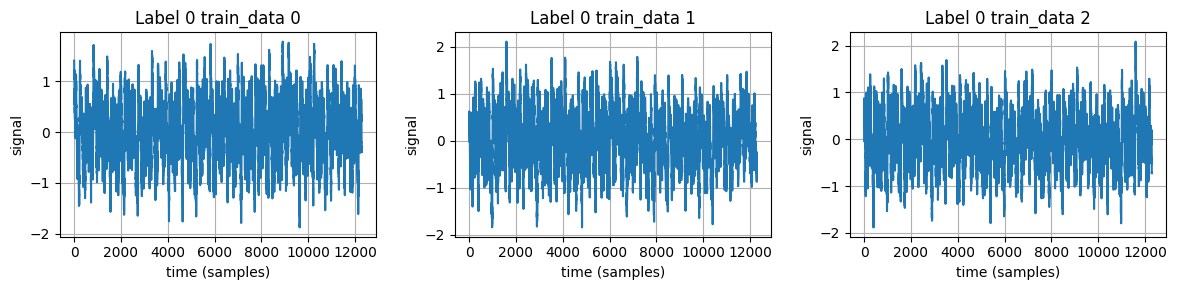

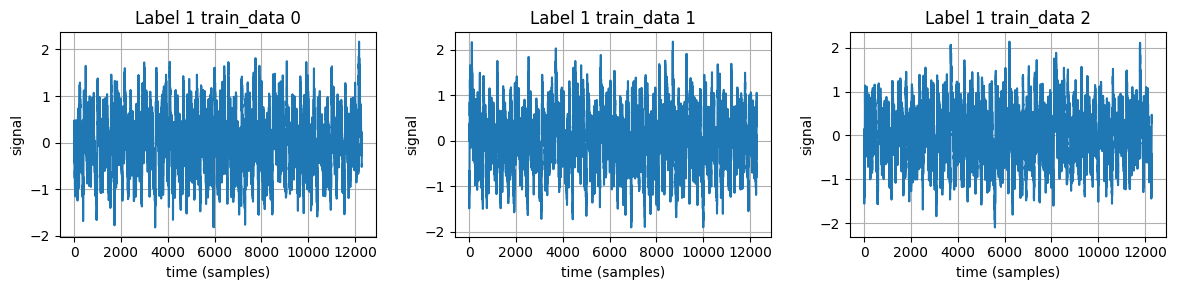

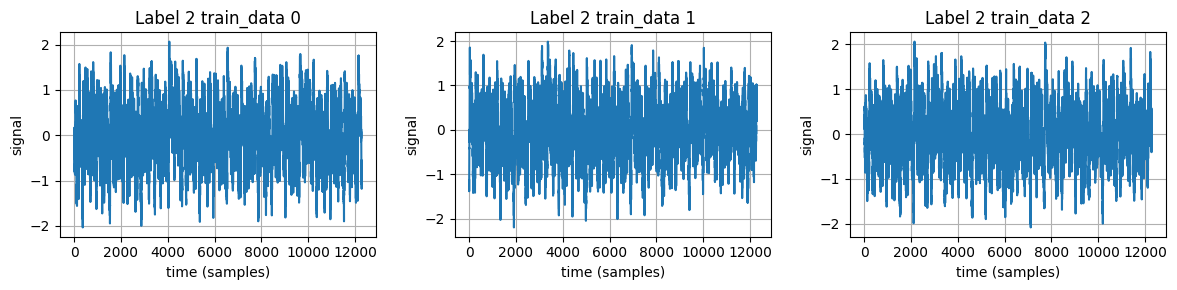

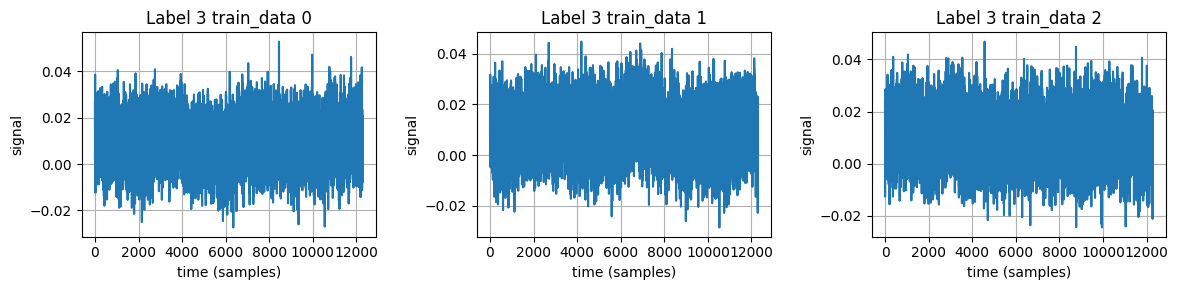

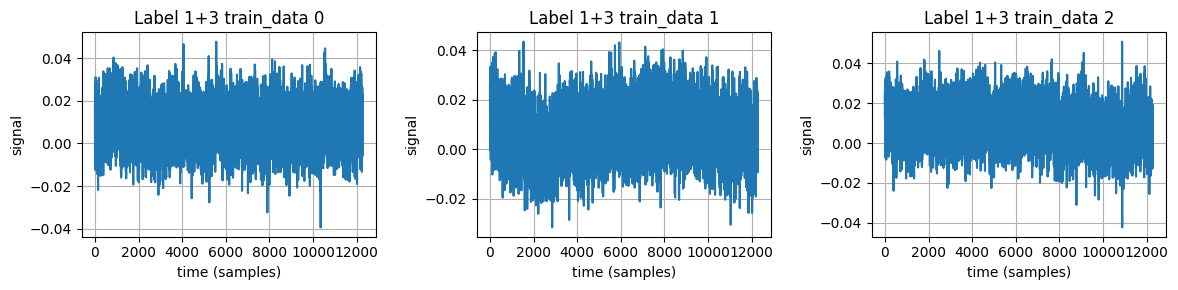

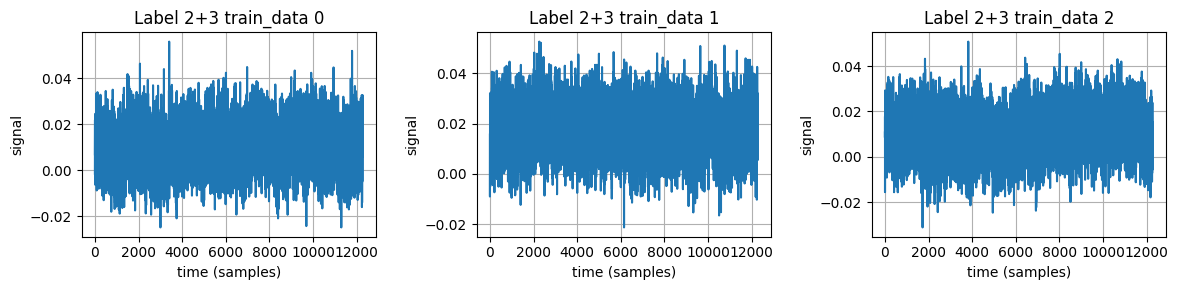

{'Label 0': [101, 55, 56], 'Label 1': [196, 219, 244], 'Label 2': [438, 436, 372], 'Label 3': [678, 695, 584], 'Label 1+3': [750, 742, 794], 'Label 2+3': [925, 1023, 950]}


In [12]:
chosen = plot_input(n=3)
print(chosen)

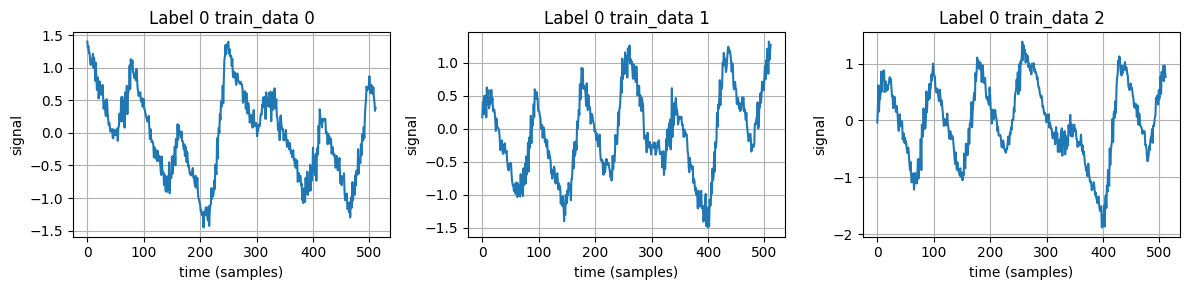

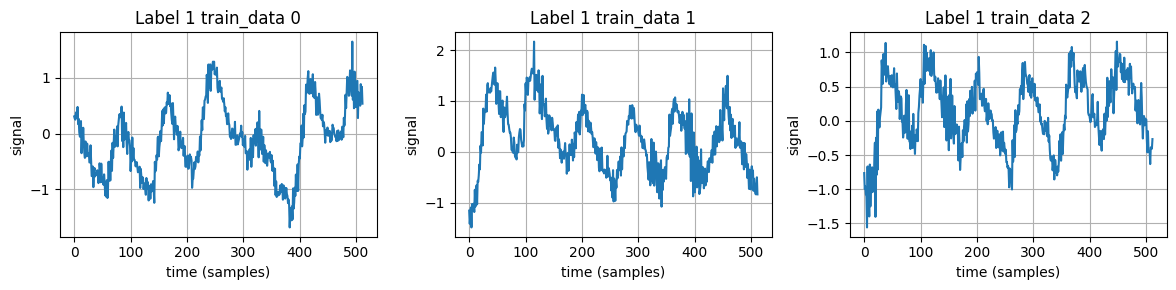

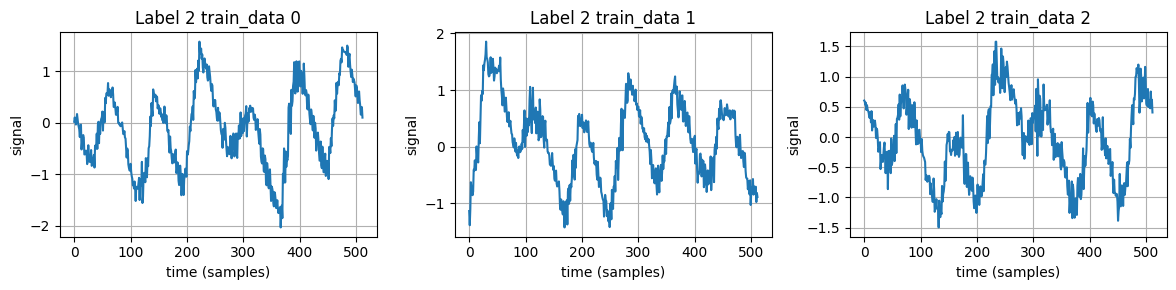

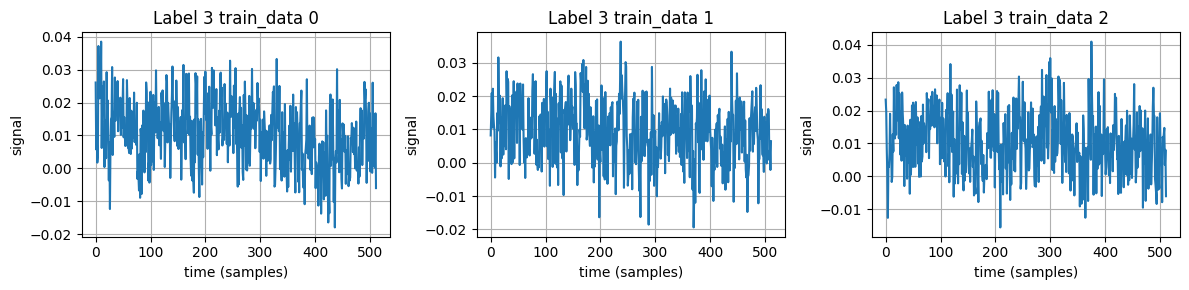

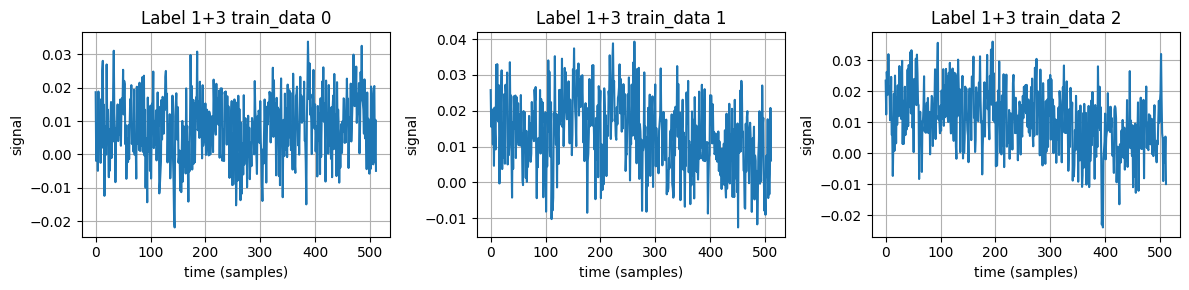

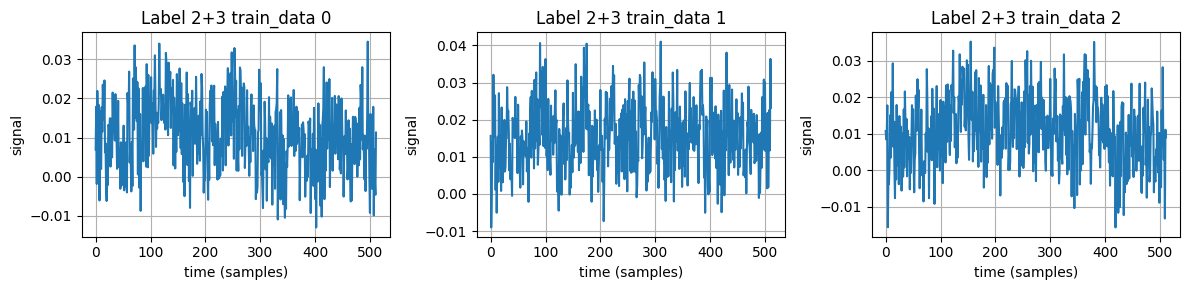

{'Label 0': [101, 55, 56], 'Label 1': [196, 219, 244], 'Label 2': [438, 436, 372], 'Label 3': [678, 695, 584], 'Label 1+3': [750, 742, 794], 'Label 2+3': [925, 1023, 950]}


In [13]:
chosen2 = plot_input2(n=3)
print(chosen2)

In [14]:
# 構建和編譯 DDCNN 模型
input_shape = (X_train.shape[1], 1)
cnn_model = build_feature_extractor(input_shape)

# 先拿 CNN 輸出 shape，動態決定 Capsule 的輸入形狀
dummy_input = tf.keras.Input(shape=input_shape)
dummy_output = cnn_model(dummy_input)
capsule_input_shape = dummy_output.shape[1:]  # (time_steps, channels)

# 用正確的 shape 建立 capsule classifier
capsule_classifier = build_capsule_classifier(
    input_shape=capsule_input_shape,
    num_capsules=10,
    capsule_dim=16,
    num_classes=num_classes
)

# 串接 CNN 和 capsule classifier
inputs = tf.keras.Input(shape=input_shape)
x = cnn_model(inputs)

outputs = capsule_classifier(x)

ddcnn_model = tf.keras.Model(inputs, outputs)
ddcnn_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# 訓練模型
ddcnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))


# 預測並分析結果
y_pred = ddcnn_model.predict(X_test)
phi = 0.5  # 閾值

# 將預測結果轉換為多標籤格式
y_pred_labels = (y_pred > phi).astype(int)

# 輸出每個測試數據的編號、原始和預測標籤，並判斷正確性
for idx, (true_labels, pred_labels) in enumerate(zip(y_test, y_pred_labels)):
    correct = np.array_equal(true_labels, pred_labels)
    result = "Correct" if correct else "Incorrect"
    print(f"Test Data {idx + 1}:")
    print(f"  Original Labels: {true_labels}")
    print(f"  Predicted Labels: {pred_labels}")
    print(f"  Result: {result}")

# 初始化每個資料夾的測試數據統計
folder_test_count = defaultdict(int)
folder_correct_count = defaultdict(int)

# 倒推出原始標籤所屬的資料夾
def get_folder_by_labels(labels):
    for folder, mapped_labels in labels_map.items():
        if set(labels) == set(mapped_labels):
            return folder
    return "Unknown"

# 統計測試數據及準確性
for idx, (true_labels, pred_labels) in enumerate(zip(y_test, y_pred_labels)):
    folder = get_folder_by_labels(np.where(true_labels == 1)[0].tolist())
    folder_test_count[folder] += 1
    if np.array_equal(true_labels, pred_labels):
        folder_correct_count[folder] += 1

# 計算每個資料夾的準確度並輸出
print("\nTest Data Accuracy by Folder:")
for folder in folder_test_count.keys():
    total = folder_test_count[folder]
    correct = folder_correct_count[folder]
    accuracy = correct / total if total > 0 else 0
    print(f"  {folder}: {total} test samples, {accuracy:.2%} accuracy")


# 計算總準確性
success_count = np.sum(np.all(y_pred_labels == y_test, axis=1))
total_count = len(y_test)

# 總測試成功率
print(f"Number of successful predictions: {success_count} out of {total_count}")
print(f"Overall Accuracy: {success_count / total_count:.2%}")

# 計算多標籤混淆矩陣
multi_confusion_matrix = multilabel_confusion_matrix(y_test, y_pred_labels)

# 顯示每個標籤的混淆矩陣
for i, cm in enumerate(multi_confusion_matrix):
    print(f"\nConfusion Matrix for Label {i}:")
    print(cm)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - accuracy: 0.2760 - loss: 0.3681 - val_accuracy: 0.3524 - val_loss: 0.2762
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3788 - loss: 0.2664 - val_accuracy: 0.3429 - val_loss: 0.2764
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3212 - loss: 0.2644 - val_accuracy: 0.3746 - val_loss: 0.2740
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3289 - loss: 0.2700 - val_accuracy: 0.3524 - val_loss: 0.2650
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3317 - loss: 0.2631 - val_accuracy: 0.3429 - val_loss: 0.2737
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4190 - loss: 0.2563 - val_accuracy: 0.5556 - val_loss: 0.2494
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4855 - loss: 0.2325 - val_accuracy: 0.6190 - val_loss: 0.1989
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5130 - loss: 0.1842 - val_accuracy: 0.5619 -

In [18]:
# --- 修正後的準確率計算邏輯 ---

total_count = len(y_test)
strict_success_count = 0      # 嚴格成功計數器
acceptable_success_count = 0  # 可接受的成功計數器

# 初始化用於計算各資料夾準確率的計數器
folder_test_count = Counter()
folder_correct_count = Counter() # 基於 "可接受" 標準的正確計數

# 遍歷每一筆測試資料
for i in range(total_count):
    y_true = y_test[i]
    y_pred = y_pred_labels[i]

    # 取得此筆測試資料的原始資料夾名稱並計數
    folder_name = folders_in_test[i]
    folder_test_count[folder_name] += 1

    is_acceptably_correct = False

    # 情況 1: 嚴格比對，預測與真實標籤完全相同
    if np.array_equal(y_true, y_pred):
        strict_success_count += 1
        is_acceptably_correct = True
    else:
        # 情況 2: 可接受的部份正確
        is_true_single_fault = (np.sum(y_true) == 1)
        is_pred_composite_fault = (np.sum(y_pred) > 1)

        if is_true_single_fault and is_pred_composite_fault:
            if np.array_equal(np.bitwise_and(y_true, y_pred), y_true):
                is_acceptably_correct = True

    # 如果這筆預測被判定為 "可接受的正確"，則更新整體與個別資料夾的計數器
    if is_acceptably_correct:
        acceptable_success_count += 1
        folder_correct_count[folder_name] += 1


# --- 打印兩種準確率結果 ---

print("----- 準確率評估報告 -----")

# 1. 嚴格準確率 (Strict Accuracy)
print(f"嚴格成功預測數量 (完全匹配): {strict_success_count} / {total_count}")
print(f"嚴格整體準確率 (Strict Accuracy): {strict_success_count / total_count:.2%}")
print("-" * 30)

# 2. 可接受準確率 (Acceptable Accuracy)
print(f"可接受的成功預測數量 (包含部分正確): {acceptable_success_count} / {total_count}")
print(f"可接受的整體準確率 (Acceptable Accuracy): {acceptable_success_count / total_count:.2%}")

# --- 新增：計算並輸出每個資料夾的 "可接受" 準確率 ---
print("\n----- 各資料夾可接受準確率 -----")
# 依您定義的順序遍歷，確保輸出順序一致
for folder in labels_map.keys():
    total = folder_test_count[folder]
    # 只有當該資料夾確實有測試樣本時才進行計算與打印
    if total > 0:
        correct = folder_correct_count[folder]
        accuracy = correct / total
        print(f"  {folder}: {total} test samples, {accuracy:.2%} accuracy")


# --- 多標籤混淆矩陣 (此部分不變) ---
print("\n\n----- 各標籤獨立混淆矩陣 -----")
multi_confusion_matrix = multilabel_confusion_matrix(y_test, y_pred_labels)

# 為了方便解讀，我們定義標籤名稱
label_names = ["正常(0)", "齒輪磨耗(1)", "齒輪不對中(2)", "軸承內斷(3)"]
for i, cm in enumerate(multi_confusion_matrix):
    print(f"標籤 '{label_names[i]}' 的混淆矩陣:")
    print(cm)
    print("") # 增加間隔

----- 準確率評估報告 -----
嚴格成功預測數量 (完全匹配): 257 / 315
嚴格整體準確率 (Strict Accuracy): 81.59%
------------------------------
可接受的成功預測數量 (包含部分正確): 312 / 315
可接受的整體準確率 (Acceptable Accuracy): 99.05%

----- 各資料夾可接受準確率 -----
  齒輪正常、軸承正常: 53 test samples, 100.00% accuracy
  齒輪磨耗、軸承正常: 63 test samples, 100.00% accuracy
  齒輪不對中、軸承正常: 56 test samples, 100.00% accuracy
  齒輪正常、軸承內斷: 55 test samples, 100.00% accuracy
  齒輪磨耗、軸承內斷: 37 test samples, 100.00% accuracy
  齒輪不對中、軸承內斷: 51 test samples, 94.12% accuracy


----- 各標籤獨立混淆矩陣 -----
標籤 '正常(0)' 的混淆矩陣:
[[262   0]
 [  0  53]]

標籤 '齒輪磨耗(1)' 的混淆矩陣:
[[164  51]
 [  0 100]]

標籤 '齒輪不對中(2)' 的混淆矩陣:
[[187  21]
 [  0 107]]

標籤 '軸承內斷(3)' 的混淆矩陣:
[[172   0]
 [  0 143]]

